In [1]:
import tensorflow as tf
import numpy as np
import librosa
import os
from IPython.display import Audio
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from 

In [2]:
audio_data = 'samples/guital_samples/'
files_on_dir = sorted(os.listdir(audio_data))
#          0      1     10    11     12    13    14     15    16    17     18    19      2    20    21     22    3       4     5      6     7      8     9 
notes = ['D#4', 'E4', 'C#5', 'D5', 'D#5', 'E5', 'F5', 'F#5', 'G5', 'G#5', 'A5', 'A#5', 'F4', 'B5', 'C6', 'C#6', 'F#4', 'G4', 'G#4', 'A4', 'A#4', 'B4', 'C5',
         'A#3', 'B3', 'G#4', 'A4', 'A#4', 'B4', 'C5', 'C#5', 'D5', 'D#5', 'E5', 'F5',  'C4', 'F#5','G5', 'G#5', 'C#4', 'D4', 'D#4', 'E4', 'F4', 'F#4', 'G4',
         'F#3', 'G3', 'E4',  'F4', 'F#4', 'G4', 'G#4', 'A4', 'A#4','B4',  'C5', 'C#5', 'G#3', 'D5','D#5', 'E5', 'A3', 'A#3', 'B3',  'C4', 'C#4', 'D4', 'D#4',
         'C#3', 'D3', 'B4',  'C4', 'C#4', 'D4', 'D#4', 'E4', 'F4', 'F#4', 'G4', 'G#4', 'D#3', 'A4',       'B4', 'E3', 'F3', 'F#3',  'G3', 'G#3', 'A3', 'A#3',
         'G#2', 'A2', 'F#3', 'G3', 'G#3', 'A3', 'A#3', 'B4',  'C4', 'C#4', 'D4', 'D#4','A#2', 'E4', 'F4', 'F#4', 'B2', 'C3', 'C#3', 'D3', 'D#3', 'E3', 'F3',
         'D#2', 'E2', 'C#3', 'D3', 'D#3', 'E3', 'F3',  'F#3', 'G3', 'G#3', 'A3', 'A#3','F2',  'B4', 'C4', 'C#4', 'F#2', 'G2', 'G#2', 'A2','A#2', 'B2', 'C3']
notes = np.array(notes)

In [3]:
raw_samples = []
for sound in files_on_dir:
    raw_samples.append(librosa.load(audio_data + sound)[0])
raw_samples = np.array(raw_samples)
min = 10000000
for i in range(len(raw_samples)):
    if min > raw_samples[i].shape[0]:
        min = raw_samples[i].shape[0]
#print(min)
for i in range(len(raw_samples)):
    if raw_samples[i].shape[0] > min:
        raw_samples[i] = raw_samples[i][:min]

C:\Users\detam\AppData\Local\Temp\ipykernel_13224\1267732838.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  raw_samples = np.array(raw_samples)


In [4]:
stft_arr = []
for tone in raw_samples:
    stft_arr.append(np.abs(librosa.stft(y=tone))[:1025])
stft_arr = np.array(stft_arr)

import random
test_indexes = []
for i in range(10):
    test_indexes.append(random.randrange(len(stft_arr)))
test_indexes = np.array(test_indexes)

labelEncoder = LabelEncoder() 
integer_encoded = labelEncoder.fit_transform(notes)

In [5]:
stft_arr.shape

(137, 1025, 173)

In [6]:
x_test = []
y_test = []
x_test = stft_arr[test_indexes]
y_test = integer_encoded[test_indexes]


x_train = np.delete(stft_arr, test_indexes, axis=0)
y_train_encoded = np.delete(integer_encoded, test_indexes, axis=0)

In [7]:
x_test = np.array(x_test)
y_test = np.array(y_test)

In [8]:
train_size = x_train.shape[0] # = 128
batch_size = 4
test_size = x_test.shape[0] # = 9
label_size = max(integer_encoded)

In [9]:
train_dataset_x = tf.data.Dataset.from_tensor_slices(np.expand_dims(x_train, axis=3))
train_dataset_y = tf.data.Dataset.from_tensor_slices(y_train_encoded)
test_dataset_x = tf.data.Dataset.from_tensor_slices(np.expand_dims(x_test, axis=3))
test_dataset_y = tf.data.Dataset.from_tensor_slices(y_test)

In [10]:
train_dataset_xy = tf.data.Dataset.zip((train_dataset_x, train_dataset_y))
train_dataset_xy = train_dataset_xy.shuffle(train_size).batch(batch_size)

test_dataset_xy = tf.data.Dataset.zip((test_dataset_x, test_dataset_y))
test_dataset_xy = test_dataset_xy.shuffle(train_size).batch(batch_size)

print(train_dataset_xy)
print(test_dataset_xy)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 1025, 173, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 1025, 173, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [11]:
Audio(data=librosa.istft(x_train[0]), rate=22050)

In [12]:
epochs = 100
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 64
#num_examples_to_generate = 16

In [13]:
class CVAE(tf.keras.Model):
  """Conditional variational autoencoder."""

  def __init__(self, latent_dim, label_size):
    super(CVAE, self).__init__()
    (self.latent_dim, self.label_size) = (latent_dim, label_size)
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(1025, 173, label_size + 1)),
            tf.keras.layers.Conv2D(
                filters=128, kernel_size=3, strides=(2,2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2,2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim + label_size,)),
            tf.keras.layers.Dense(units=255*42*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(255, 42, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='valid',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=128, kernel_size=3, strides=2, padding='valid',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='valid'),
            #tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=1, strides=1, padding='same')
        ]
    )

  @tf.function
  def sample(self, eps=None, y=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, y, apply_sigmoid=True)

  def encode(self, x, y):
    n_sample = x.shape[0]
    #print(f'n_sample:{n_sample}')
    image_size = x.shape[1:3]
    #print(f'image_size:{image_size}')
    y_onehot = tf.reshape(tf.one_hot(y, self.label_size), [n_sample, 1, 1, self.label_size]) # 1 x 1 x label_size
    #print(f'y_onehot:{y_onehot}')
    k = tf.ones([n_sample, *image_size, 1]) # {image_size} x 1
    #print(f'k:{k}')
    x = tf.reshape(x, [x.shape[0], x.shape[1], x.shape[2], 1])
    h = tf.concat([x, k * y_onehot], 3) # {image_size} x (1 + label_size)
    #print(f'h:{h}')
    mean, logvar = tf.split(self.encoder(h), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, y=None, apply_sigmoid=False):
    n_sample = z.shape[0]
    if not y is None:
      y_onehot = tf.reshape(tf.one_hot(y, self.label_size), [n_sample, self.label_size]) # label_size
      #print(f'y_onehot_decode: {y_onehot}')
      h = tf.concat([z, y_onehot], 1) # latent_dim + label_size
      #print(f'h_decode: {h}')
    else:
      h = tf.concat([z, tf.zeros([n_sample, self.label_size])], 1)  # latent_dim + label_size
    logits = self.decoder(h)
    #print(f'logits: {logits}')
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits


optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, xy):
  (x, y) = xy # x: image, y: label
  mean, logvar = model.encode(x, y)
  z = model.reparameterize(mean, logvar)
  #print(f'y: {y}')
  #print(f'z: {z}')
  x_logit = model.decode(z, y)
  #print(f'x_logit: {x_logit}')
  #print(f'mean and logvar:{mean} & {logvar}')
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, xy, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, xy)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))



In [14]:
model = CVAE(latent_dim, max(integer_encoded) + 1)
print(model.encoder.summary())
print('')
print(model.decoder.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 512, 86, 128)      55424     
                                                                 
 conv2d_1 (Conv2D)           (None, 255, 42, 64)       73792     
                                                                 
 flatten (Flatten)           (None, 685440)            0         
                                                                 
 dense (Dense)               (None, 128)               87736448  
                                                                 
Total params: 87,865,664
Trainable params: 87,865,664
Non-trainable params: 0
_________________________________________________________________
None

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)

In [15]:
import time

In [16]:
for epoch in range(1, 20+1):
  start_time = time.time()
  for train in train_dataset_xy:
    train_step(model, train, optimizer)
  end_time = time.time()

  loss_tr = tf.keras.metrics.Mean()
  for train in train_dataset_xy:
    loss_tr(compute_loss(model, train))
  elbo_tr = -loss_tr.result()

  loss_tst = tf.keras.metrics.Mean()
  for test in test_dataset_xy:
    loss_tst(compute_loss(model, test))
  elbo_tst = -loss_tst.result()
  # display.clear_output(wait=False)
  print(f'Epoch: {epoch}, time elapse for current epoch: {end_time - start_time} \n train loss elbo: {elbo_tr} \n test loss elbo: {elbo_tst}')

Epoch: 1, time elapse for current epoch: 98.92973518371582 
 train loss elbo: -37326.1015625 
 test loss elbo: -33859.328125
Epoch: 2, time elapse for current epoch: 95.57662558555603 
 train loss elbo: -25242.66015625 
 test loss elbo: -26278.478515625
Epoch: 3, time elapse for current epoch: 95.61397075653076 
 train loss elbo: -23597.544921875 
 test loss elbo: -24902.857421875
Epoch: 4, time elapse for current epoch: 95.0487334728241 
 train loss elbo: -22562.21484375 
 test loss elbo: -23667.755859375
Epoch: 5, time elapse for current epoch: 94.9725615978241 
 train loss elbo: -22549.72265625 
 test loss elbo: -22936.162109375
Epoch: 6, time elapse for current epoch: 94.95930981636047 
 train loss elbo: -21850.255859375 
 test loss elbo: -22826.453125
Epoch: 7, time elapse for current epoch: 94.67259645462036 
 train loss elbo: -21563.568359375 
 test loss elbo: -22782.232421875
Epoch: 8, time elapse for current epoch: 94.55460667610168 
 train loss elbo: -21232.17578125 
 test lo

In [17]:
def generate_stft(model, test_sample):
  mean, logvar = model.encode(*test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z, test_sample[1])
  data = np.array(predictions[np.random.randint(0,2)])
  data = np.reshape(data, (data.shape[0], data.shape[1]))
  return data


In [18]:
assert batch_size >= 1
for test_batch in test_dataset_xy.take(1):
  test_sample = (test_batch[0][0:2, :,  :, :], test_batch[1][0:2])

In [19]:
data = generate_stft(model, test_sample)
Audio(data=librosa.istft(data), rate=22050)


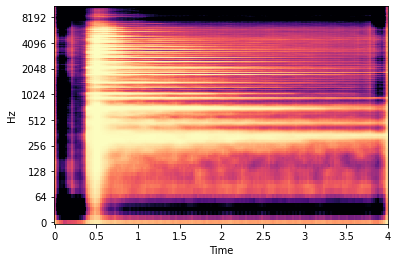

In [20]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(nrows=1, sharex=True)
librosa.display.specshow(librosa.amplitude_to_db(data, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax)

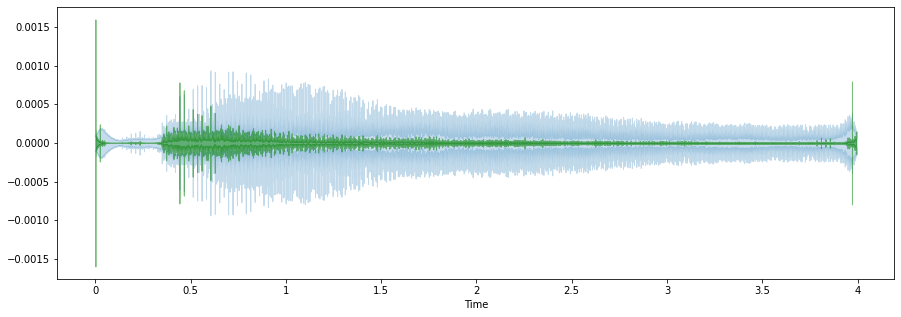

In [21]:
y_harmonic, y_percussive = librosa.effects.hpss(librosa.istft(data))
plt.figure(figsize=(15, 5))
librosa.display.waveshow(y_harmonic, sr=22050, alpha=0.25)
librosa.display.waveshow(y_percussive, sr=22050, color='green', alpha=0.5)

C:\Users\detam\AppData\Local\Temp\ipykernel_13224\2002993172.py:2: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.display.specshow(librosa.amplitude_to_db(librosa.stft(y_percussive), ref=np.max),


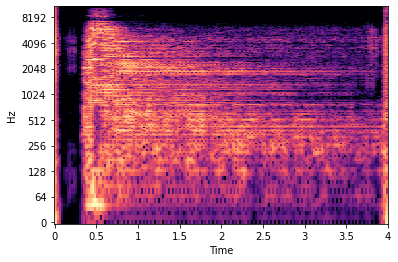

In [22]:
fig, ax = plt.subplots(nrows=1, sharex=True)
librosa.display.specshow(librosa.amplitude_to_db(librosa.stft(y_percussive), ref=np.max),
                         y_axis='log', x_axis='time', ax=ax)